# Analiza wysokości budynków na podstawie danych wysokościowych oraz BDOT
### Opis
W poniższym notatniku przeprowadzony zostanie proces obliczenia wysokości budynków znajdujących sie w bazie BDOT10k na podstawie numerycznego modelu terenu oraz numerycznego modelu pokrycia terenu. Z wykorzystaniem biblioteki _RasterFrames_ połączone zostaną dane z NMT i NMPT w celu uzyskania znormalizowanego NMPT, w oparciu o które będzie możliwe późniejsze przypisanie wysokości budynków obiektom wektorowym z bazy BDOT. Ostatecznie wyniki zostaną zwizualizowane.
### Narzędzia/biblioteki
__cenagis__ - wczytanie danych z bazy Accumulo, inicjalizacja kontekstu Spark, wizualizacja wyników<br>
__RasterFrames__ - Operacje na danych rastrowych, rasteryzacja danych wektorowych o budynkach (https://rasterframes.io//index.html)<br>
__GeoMesa__ - Operacje na danych wektorowych (https://www.geomesa.org/documentation/stable/index.html)

## Konfiguracja środowiska
### Import bibliotek
Należy zaimportować biblioteki potrzebne na dalszych etapach analizy

In [1]:
import cenagis
import pyrasterframes
from pyrasterframes.rasterfunctions import *
import pyrasterframes.rf_ipython
from pyspark.sql.functions import lit, col,  broadcast
from branca.colormap import linear

### Inicjalizacja kontekstu Spark
W procesie inicjalizacji kontekstu Spark konieczne jest dodanie pakietu _pyrasterframes_ oraz inicjalizacja z poleceniem
```python
    .withRasterFrames()
```
W innym wypadku nie będzie możliwe wykorzystanie możliwości biblioteki _RasterFrames_

In [2]:
conf = cenagis.spark.generate_spark_configuration(
    app_name='rasterframes basics', executor_cores=4, executor_memory='16g', executor_gpu=0, max_cpu=32)
conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
spark = cenagis.spark.init_spark_with_configuration(conf).withRasterFrames()

Spark UI available at: https://fb3ebe12-c7a3-4798-803f-2759068fcb70.dcsvc.cenagis.edu.pl


## Wczytanie danych
Do przeprowadzenia analizy konieczne będą trzy zestawy danych:
1. budynki z bazy danych BDOT10k
2. Numeryczny Model Terenu pozyskany z zasobów GUGiK
3. Numeryczny Model Pokrycia Terenu pozyskany z zasobów GUGiK

### BDOT
Dane o budynkach z BDOT (tabela BUBD) zaostanie zaimportowana z bazy Accumulo dzięki narzędziu GeoMesa.<br>
Konieczne będą późniejsze operacje z wykorzystaniem języka SparkSQL, musi więc zostać utworzony tymczasowy widok umożliwiający odwoływanie się do tych danych z poziomu SparkSQL:
``` python
bubd.createOrReplaceTempView("bubd")
```

In [3]:
bubd = cenagis.geomesa.get_geomesa_dataframe("cenagis.bdot", "ot_bubd_a").select(
    '__fid__', 'gmlid_pelny', 'lokalny_id', 'liczbakondygnacji', 'funkcjaogolnabudynku_full', 'geom').cache()
bubd.createOrReplaceTempView('bubd')
bubd.show(5)

+--------------------+--------------------+--------------------+-----------------+-------------------------+--------------------+
|             __fid__|         gmlid_pelny|          lokalny_id|liczbakondygnacji|funkcjaogolnabudynku_full|                geom|
+--------------------+--------------------+--------------------+-----------------+-------------------------+--------------------+
|000017cc-8e67-451...|PL.PZGiK.337.0208...|2F4C3943-80BF-BB5...|                2|     budynkiMieszkalne...|POLYGON ((16.4853...|
|000017cc-8e5a-444...|PL.PZGiK.337.0208...|2F4C3943-26C5-BB5...|                2|     budynkiMieszkalne...|POLYGON ((16.6636...|
|000017cc-8e5a-446...|PL.PZGiK.337.0208...|2F4C3943-0210-BB5...|                2|     budynekGospodarst...|POLYGON ((16.6625...|
|000017cc-8e5a-446...|PL.PZGiK.337.0208...|2F4C3943-26A3-BB5...|                2|     budynkiMieszkalne...|POLYGON ((16.6670...|
|000017cc-8e5a-447...|PL.PZGiK.337.0208...|2F4C3943-0310-BB5...|                1|     bud

### NMT
Dane rastrowe zostaną wczytane z _HDFS_ z pomocą bibliteki _RasterFrames_. Ze względu na późniejsze operacje przestrzenne warto włączyć partycjonowanie przestrzenne danych (przyspieszy to późniejsze operacje):
```python
spatial_index_partitions=True
```
Z zaimportowanych danych należy odrzucić te kafelki, które nie zawierają żadnych informacji. W tym celu obliczone zostaną statystyki dla każdego z kafelków, a następnie odrzucone będą te, które nie zawierają, żednych informacji:
```python
.withColumn('stats',rf_tile_stats('proj_raster'))
.where('stats.data_cells is not null')
```

proj_raster_path,nmt,spatial_index,stats
hdfs:///data_pre/nmt/waw_nmt.tif,,80480791710,"[8114, 57422, 109.66999816894531, 112.30000305175781, 111.32368504216525, 0.14775727190317411]"
hdfs:///data_pre/nmt/waw_nmt.tif,,80480792628,"[9287, 56249, 111.0999984741211, 113.43000030517578, 112.48696784320042, 0.15331435023836093]"
hdfs:///data_pre/nmt/waw_nmt.tif,,80480792649,"[7771, 57765, 112.18000030517578, 113.83999633789062, 113.08033196362516, 0.2071673193895549]"
hdfs:///data_pre/nmt/waw_nmt.tif,,80480792756,"[49859, 15677, 107.55999755859375, 111.9800033569336, 110.88379568472081, 0.130412938840891]"
hdfs:///data_pre/nmt/waw_nmt.tif,,80480792756,"[63023, 2513, 109.62000274658203, 113.04000091552734, 111.67087080120679, 0.2917766479549755]"

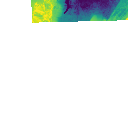
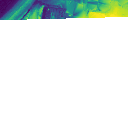
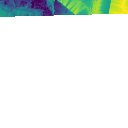
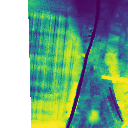
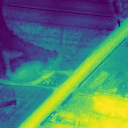

In [4]:
df_nmt = spark.read.raster('hdfs:///data_pre/nmt/waw_nmt.tif', lazy_tiles=True, spatial_index_partitions=True)\
    .withColumn('stats', rf_tile_stats('proj_raster'))\
    .where('stats.data_cells is not null')\
    .withColumnRenamed('proj_raster', 'nmt').cache()
df_nmt

### NMPT
Dane NMPT zostaną wczytane w ten sam sposób jak dane NMT:

proj_raster_path,nmpt,spatial_index,stats
hdfs:///data_pre/nmpt/waw_nmpt.tif,,80480792392,"[637, 64899, 103.36000061035156, 109.51000213623047, 104.22797509976421, 1.7148116146508983]"
hdfs:///data_pre/nmpt/waw_nmpt.tif,,80480792562,"[3161, 62375, 103.11000061035156, 106.8499984741211, 106.37412212242698, 0.12312057190138148]"
hdfs:///data_pre/nmpt/waw_nmpt.tif,,80480792536,"[1910, 63626, 103.63999938964844, 108.62000274658203, 105.56882191603097, 0.2208261862742802]"
hdfs:///data_pre/nmpt/waw_nmpt.tif,,80480792756,"[59468, 6068, 107.37000274658203, 113.02999877929688, 110.9615899444773, 0.17012110290852434]"
hdfs:///data_pre/nmpt/waw_nmpt.tif,,80480792756,"[65504, 32, 109.4800033569336, 146.63999938964844, 111.99306103632283, 2.078294737724718]"

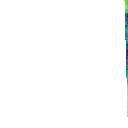
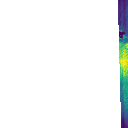
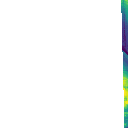
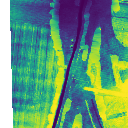
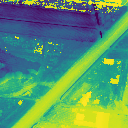

In [5]:
df_nmpt = spark.read.raster('hdfs:///data_pre/nmpt/waw_nmpt.tif', lazy_tiles=True, spatial_index_partitions=True)\
    .withColumn('stats', rf_tile_stats('proj_raster'))\
    .where('stats.data_cells is not null')\
    .withColumnRenamed('proj_raster', 'nmpt').cache()
df_nmpt

## Obliczenie rastra zNMPT
W celu obliczenia wysokości budynków należy obliczyć raster zNMPT (znormalizowane NNPT), które powstaje w wyniku odjęcia wartości rastra NMPT od rastra NMT.<br>
Pierwszym krokiem jest połączenie danych zawierających dane NMT i NMPT. W tym celu wykorzystanie zostanie funkcja `raster_join`. (więcej informacji: https://rasterframes.io//raster-join.html)<br>
Następnie należy otworzyć kafelki zNMPT odejmując wartości NMPT i NMT przy pomocy funkcji `rf_local_substract`.

In [6]:
df_znmpt = df_nmpt.raster_join(df_nmt).cache()
df_znmpt = df_znmpt.withColumn("z_nmpt", rf_local_subtract("nmpt", "nmt"))
df_znmpt.createOrReplaceTempView("z_nmpt")

Obliczony raster należy następnie przygotować do połączenia z danymi wektorowymi z BDOT. Ze względu na założenia _GeoMesa_ dane te znajdują się w układzie __EPSG:4326__. Konieczne jest więc przetworzenie danych rastrowych właśnie do tego układu:
```python
df_znmpt.withColumn("4326_znmpt",rf_proj_raster('z_nmpt', st_extent('extent'),rf_mk_crs('EPSG:4326')))
```
Do rasteryzacji danych konieczne będą informacje o zasięgu kafelków oraz ich wymiarach - nalezy utworzyć kolumny z tymi danymi:
```python
df_znmpt.withColumn("extent",st_geometry(rf_extent('4326_znmpt')))
df_znmpt.withColumn("dims",rf_dimensions('4326_znmpt'))
```
Dla zachowania czytelności wyników warto również wybrać z tabeli jedynie istotne dla analizy kolumny:
```python
df_znmpt.select(col('4326_znmpt').alias('znmpt'),col('dims'),col('extent'))
```

znmpt,dims,extent
,"[256, 256]",POLYGON ((21.015644736452753 52.18316583...
,"[256, 256]",POLYGON ((21.012421146188128 52.19473415...
,"[256, 256]",POLYGON ((20.90225405722667 52.247219505...
,"[256, 256]",POLYGON ((20.918341271052807 52.27228767...
,"[256, 256]",POLYGON ((20.979891845605348 52.30581046...

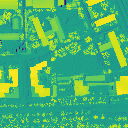
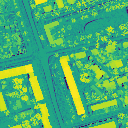
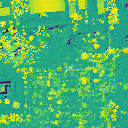
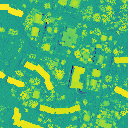
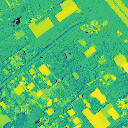

In [7]:
df_znmpt = df_znmpt.withColumn("4326_znmpt", rf_proj_raster(
    'z_nmpt', st_extent(st_geometry('extent')), rf_mk_crs('EPSG:4326')))
df_znmpt = df_znmpt.withColumn("extent", st_reproject(st_geometry(
    rf_extent('z_nmpt')), rf_mk_crs('EPSG:2180'), rf_mk_crs('EPSG:4326')))
df_znmpt = df_znmpt.withColumn("dims", rf_dimensions('4326_znmpt'))
df_znmpt = df_znmpt.select(col('4326_znmpt').alias(
    'znmpt'), col('dims'), col('extent'))
df_znmpt.createOrReplaceTempView("z_nmpt")
df_znmpt

## Rasteryzacja warstwy wektorowej
W celu rasteryzacji warstwy budynków z bazy BDOT konieczne jest połączenie ich z odpowiadającymi przestrzennie danymi zNMPT. W tym celu zastosowano zapytanie z funkcją `st_intersects` narzędzia GeoMesa, która, dla każdego obiektu poligonowego zwróci odpowiadający mu przestrzennie (przecinający się) kafelek rastrowy. 

Jako, że dane w BUBD obejmują dużo większy zasięg przestrzenny niż dane rastrowe, można przed właściwą operacją ograniczyć je tylko do otoczki wypukłej zasięgu rastra wykorzystują funkcje GeoMesa `st_convexHull`.
```python
spark.sql("SELECT * FROM bubd WHERE st_intersects(geom,(SELECT st_convexHull(z_nmpt.extent)['convexHull'] FROM z_nmpt))")
```

In [8]:
bubd_small = spark.sql(
    "SELECT * FROM bubd WHERE st_intersects(geom,(SELECT st_convexHull(z_nmpt.extent)['convexHull'] FROM z_nmpt))")

In [9]:
bubd_small.count()

116642

znmpt,dims,extent,__fid__,gmlid_pelny,lokalny_id,liczbakondygnacji,funkcjaogolnabudynku_full,geom
,"[256, 256]",POLYGON ((20.897250632527992 52.12986668...,000017cc-8a24-4384-959d-9f3f4fc5501c,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2146843,33046B6C-2567-6A83-E053-CC2BA8C063F3,1,zbiornikSilosIBudynkiMagazynowe,POLYGON ((20.899910843648932 52.13103344...
,"[256, 256]",POLYGON ((20.897544003472156 52.13676986...,000017cc-8a24-43b1-a092-55558dcce341,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2112880,33046B6C-0D6C-6A83-E053-CC2BA8C063F3,1,budynkiHandlowoUslugowe,POLYGON ((20.90133544136632 52.137846609...
,"[256, 256]",POLYGON ((20.90128350688316 52.136709622...,000017cc-8a24-43b1-a092-55558dcce341,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2112880,33046B6C-0D6C-6A83-E053-CC2BA8C063F3,1,budynkiHandlowoUslugowe,POLYGON ((20.90133544136632 52.137846609...
,"[256, 256]",POLYGON ((20.88977274095237 52.129986791...,000017cc-8a24-43b8-8e9f-0d6ae261a067,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2146796,33046B6C-2BC6-6A83-E053-CC2BA8C063F3,1,zbiornikSilosIBudynkiMagazynowe,POLYGON ((20.89214590532017 52.131889324...
,"[256, 256]",POLYGON ((20.8753000443247 52.1417310258...,000017cc-8a24-43ba-9094-54f9c5260300,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.216877,33046B6C-426A-6A83-E053-CC2BA8C063F3,1,budynekGospodarstwaRolnego,POLYGON ((20.876950058660604 52.14357610...

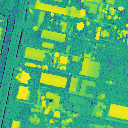
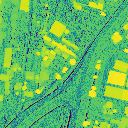
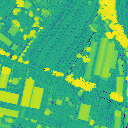
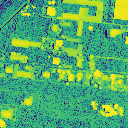
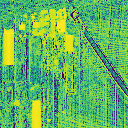

In [10]:
znmpt_bubd = df_znmpt.join(bubd_small, st_intersects(
    "extent", 'geom'), how='right').cache()
znmpt_bubd.createOrReplaceTempView('znmpt_bubd')
znmpt_bubd

Następnie, korzystając z funkcji RasterFrames `rf_rasterize()`:
```python
znmpt_bubd.withColumn("build_raster",rf_rasterize('geometry','extent',lit(0),'dims.cols','dims.rows'))
```
Dokonywana jest rasteryzacja warstwy w kolumnie _geom_. Obszar nowego rastra będzie taki sam jak obszar kafelka zNMPT (kolumna `extent`), wypełniony wartościami __0__ (`lit(0)`) oraz posiadający rozdzielczość identyczną z kafelkiem zNMPT (kolumna _dims_)<br>
Następnie korzystając z funkcji `rf_mask()` możliwe jest przeniesienie wartości z rastra zNMPT na nową warstwę rastrową z budynkami:
```python
znmpt_bubd.withColumn("build_height",rf_mask('znmpt', 'build_raster'))
```

znmpt,dims,extent,__fid__,gmlid_pelny,lokalny_id,liczbakondygnacji,funkcjaogolnabudynku_full,geom,build_raster,build_height
,"[256, 256]",POLYGON ((20.897250632527992 52.12986668...,000017cc-8a24-4384-959d-9f3f4fc5501c,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2146843,33046B6C-2567-6A83-E053-CC2BA8C063F3,1,zbiornikSilosIBudynkiMagazynowe,POLYGON ((20.899910843648932 52.13103344...,,
,"[256, 256]",POLYGON ((20.897544003472156 52.13676986...,000017cc-8a24-43b1-a092-55558dcce341,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2112880,33046B6C-0D6C-6A83-E053-CC2BA8C063F3,1,budynkiHandlowoUslugowe,POLYGON ((20.90133544136632 52.137846609...,,
,"[256, 256]",POLYGON ((20.90128350688316 52.136709622...,000017cc-8a24-43b1-a092-55558dcce341,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2112880,33046B6C-0D6C-6A83-E053-CC2BA8C063F3,1,budynkiHandlowoUslugowe,POLYGON ((20.90133544136632 52.137846609...,,
,"[256, 256]",POLYGON ((20.88977274095237 52.129986791...,000017cc-8a24-43b8-8e9f-0d6ae261a067,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2146796,33046B6C-2BC6-6A83-E053-CC2BA8C063F3,1,zbiornikSilosIBudynkiMagazynowe,POLYGON ((20.89214590532017 52.131889324...,,
,"[256, 256]",POLYGON ((20.8753000443247 52.1417310258...,000017cc-8a24-43ba-9094-54f9c5260300,PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.216877,33046B6C-426A-6A83-E053-CC2BA8C063F3,1,budynekGospodarstwaRolnego,POLYGON ((20.876950058660604 52.14357610...,,

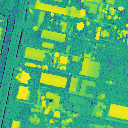
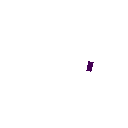
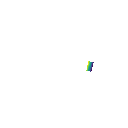
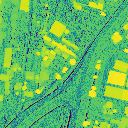
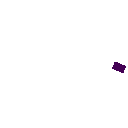
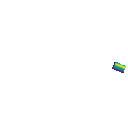
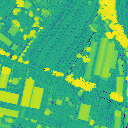
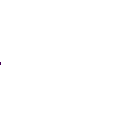
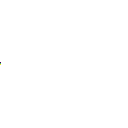
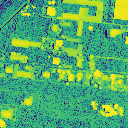
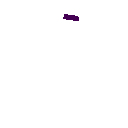
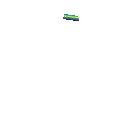
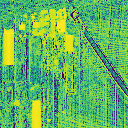
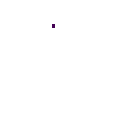
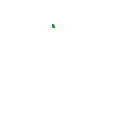

In [11]:
znmpt_bubd = znmpt_bubd.withColumn("build_raster", rf_rasterize(
    'geom', 'extent', lit(0), 'dims.cols', 'dims.rows'))
znmpt_bubd = znmpt_bubd.withColumn(
    "build_height", rf_mask('znmpt', 'build_raster'))
znmpt_bubd

Po przeniesieniu informacji na rastrową warstwę budynków możliwe jest obliczenie średniej wysokości każdego z nich (funkcja `rf_agg_mean()`).<br>
Uzyskana na tym etapie tabela będzie wykorzystana do wizualizacji oraz statystyk. Dodanie polecenia `cache()` sprawi, że wynik obliczeń zostanie zachowany w pamięci, a późniejsze przetworzenia będą realizowane szybciej.

In [12]:
mean_height = znmpt_bubd.groupby(
    'gmlid_pelny', 'geom').agg(rf_agg_mean('build_height'))
mean_height = mean_height.withColumnRenamed(
    "rf_agg_mean(build_height)", "build_height")
mean_height

gmlid_pelny,geom,build_height
PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2128946,POLYGON ((20.90368546249843 52.157016771...,5.168000139508929
PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2134287,POLYGON ((20.909753329809533 52.15776559...,3.8111371127041904
PL.PZGiK.330.1421__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.2128802,POLYGON ((20.897142588925508 52.13744013...,3.4835001627604165
PL.PZGiK.330.1465__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.6595209,POLYGON ((20.913786945097225 52.20266629...,8.824860572814941
PL.PZGiK.330.1465__OT_BUBD_A.xml#PL.PZGIK.BDOT10k.BUBDA.14.65137142,POLYGON ((21.05611697074007 52.154224525...,12.712782810222848


## Wizualizacja danych
Dane mogą być następnie zwizualizowane z wykorzystaniem modułu `cenagis.cenagisVisualization`. Ze względu na dużą ilość danych rozwiązaniem optymlanym jest wykorzystanie narzędzia __geoserver__ w procesie wizualizacji.<br>
Pierwszym etapem jest inicjalizacja mapy:
```python
cenagis.visualization.map.init_map()
```
Podkład mapowy pojawi się po prawej stronie ekranu.<br>
Następnie należy opublikować dane znajdującie się w Spark DataFrame w formie Geopackage czytelnej dla geoserver:
```python
cenagis.geoserver.publish_dataframe_as_gpkg(mean_height,'build_height')
```
Nazwa podana jako drugi argument funkcji będzie później wykorzystywana do wyświetlenia warstwy WMS z geoserver.

In [13]:
cenagis.visualization.map.init_map()
cenagis.geoserver.publish_dataframe_as_gpkg(mean_height, 'build_height')

'cenagis:build_height'

Ostatnim etapem koniecznym w procesie wizualizacji jest utworzenie stylu warstwy:
```python
cenagis.geoserver.create_choropleth_sld_style(mean_height,"build_height",colormap=linear.RdYlGn_10,invert_colormap=True, num_bins=5)
```
Konieczne jest podanie nazwy kolumny, która ma być wizualizowana (w tym przypadku jest to `build_height`) oraz paletę barw (atrybut `colormap`).
> Dostępne palaty barw można wyświetlić wywołując następujące polecenie (załadowanie wszystkich palet może chwilę potrwać):<br>
><b>linear</b>

In [14]:
mysldchoro = cenagis.geoserver.create_choropleth_style(
    mean_height, "build_height", colormap=linear.RdYlGn_10, invert_colormap=True, bins=10)
cenagis.visualization.map.remove_all_layers()
cenagis.geoserver.upload_style("mysldchoro", mysldchoro)
cenagis.visualization.map.add_local_wms_layer(
    'cenagis:build_height', style='mysldchoro', add_legend=True)

In [ ]:
linear

## Zwolnienie zasobów i zakończenie analizy
Po zakończonej analizie konieczne jest zwolnienie zasobów związanych z wizualizacją z wykorzystaniem geoserver oraz zatrzymanie kontekstu _Spark_.

In [15]:
cenagis.geoserver.clean_catalog_and_data()
spark.stop()